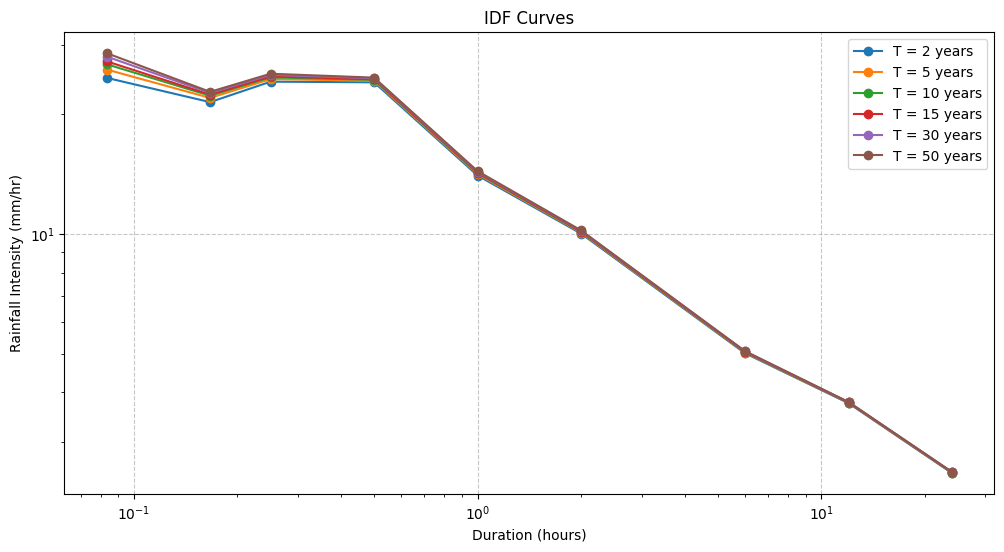

Optimized Parameters: K = 32.3879300195984, x = 0.02055901940063421, a = 1.2149050677583533, n = 0.9417387256848342


In [7]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit

# Load data from Excel file
data_path = "Dataset2.xlsx"  # Ensure correct path
data_frame = pd.read_excel(data_path)

# Convert duration from minutes to hours
time_intervals = np.array([5, 10, 15, 30, 60, 120, 360, 720, 1440]) / 60  # Hours

# Extract and normalize intensity values for each duration
intensity_data = {time: (data_frame.iloc[:, idx + 1].dropna().values) / time for idx, time in enumerate(time_intervals)}

# Store KS test results
ks_test_results = {}
chosen_distributions = {}

for duration, values in intensity_data.items():
    values_array = np.array(values)

    # Fit Log-Normal distribution
    log_vals = np.log(values_array)
    mu_ln, sigma_ln = np.mean(log_vals), np.std(log_vals)

    # Fit Gumbel distribution
    params_gumbel = st.gumbel_r.fit(values_array)

    # Perform Kolmogorov-Smirnov (KS) test
    ks_lognormal = st.kstest(values_array, lambda x: st.lognorm.cdf(x, s=sigma_ln, scale=np.exp(mu_ln)))
    ks_gumbel = st.kstest(values_array, lambda x: st.gumbel_r.cdf(x, *params_gumbel))

    ks_test_results[duration] = {"Log-Normal": ks_lognormal.statistic, "Gumbel": ks_gumbel.statistic}

    # Choose the best-fit distribution
    best_fit = "Log-Normal" if ks_lognormal.statistic < ks_gumbel.statistic else "Gumbel"
    chosen_distributions[duration] = ("lognormal", (mu_ln, sigma_ln)) if best_fit == "Log-Normal" else ("gumbel", params_gumbel)

# Define return periods
return_times = [2, 5, 10, 15, 30, 50]

# Compute IDF values
idf_results = {T: [] for T in return_times}
sorted_durations = sorted(chosen_distributions.keys())

for duration in sorted_durations:
    dist_type, params = chosen_distributions[duration]

    for T in return_times:
        probability = 1 - (1 / T)

        if dist_type == "lognormal":
            mu, sigma = params
            z_val = st.norm.ppf(probability)
            intensity = np.exp(mu + sigma * z_val)

        elif dist_type == "gumbel":
            mu, sigma = params
            intensity = mu - sigma * np.log(-np.log(probability))

        idf_results[T].append(intensity)

# Plot IDF curves
plt.figure(figsize=(12, 6))
for T in return_times:
    plt.plot(sorted_durations, idf_results[T], marker='o', label=f'T = {T} years')

plt.xlabel("Duration (hours)")
plt.ylabel("Rainfall Intensity (mm/hr)")
plt.title("IDF Curves")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

# Define an IDF equation
def idf_function(params, duration, return_period):
    K, x, a, n = params
    return (K * (return_period ** x)) / ((duration + a) ** n)

# Define the objective function for optimization
def loss_function(params, durations, return_periods, intensities):
    predicted_intensities = np.array([idf_function(params, d, t) for d, t in zip(durations, return_periods)])
    return np.sum((intensities - predicted_intensities) ** 2)

# Prepare data for fitting
d_values, t_values, i_values = [], [], []

for T, intensities in idf_results.items():
    for i, D in enumerate(sorted_durations):
        d_values.append(D)
        t_values.append(T)
        i_values.append(intensities[i])

d_values, t_values, i_values = np.array(d_values), np.array(t_values), np.array(i_values)

# Set initial parameter guesses
initial_params = [10, 0.5, 1, 0.5]

# Perform optimization using Nelder-Mead method
optimized_result = minimize(loss_function, initial_params, args=(d_values, t_values, i_values), method="Nelder-Mead")

# Extract optimized parameters
K_opt, x_opt, a_opt, n_opt = optimized_result.x
print(f"Optimized Parameters: K = {K_opt}, x = {x_opt}, a = {a_opt}, n = {n_opt}")

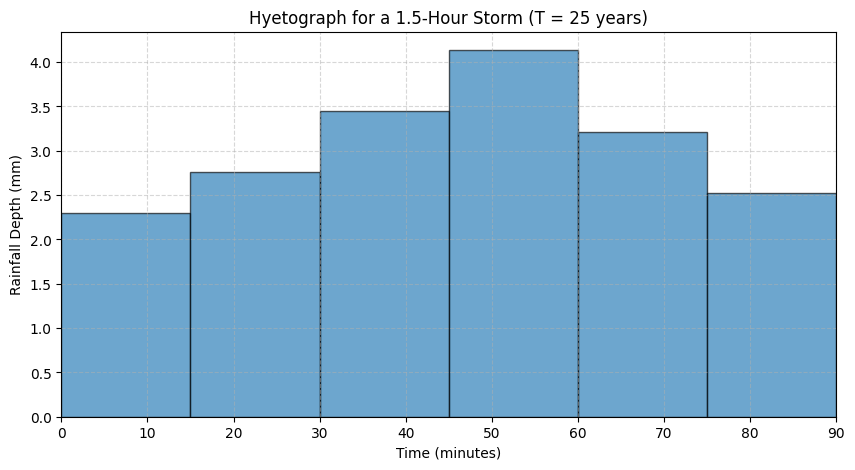

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# ---------- PARAMETERS ----------
storm_duration_hr = 1.5   # hours
T = 25                    # return period in years
intervals = 6             # number of sub-intervals for hyetograph (6 -> 15-min bins for 1.5 hr)

# ---------- Prepare arrays ----------
# ensure sorted_durations is a numpy array of durations (hours) sorted ascending
durations_arr = np.array(sorted_durations, dtype=float)
# compute intensity for the chosen return period T at each duration using chosen_distributions
intensities_for_T = []

prob = 1.0 - 1.0 / T  # exceedance probability for return period T

for d in durations_arr:
    dist_type, params = chosen_distributions[d]
    try:
        if dist_type == "lognorm" or dist_type == "lognormal":
            # params from earlier code: (s, loc, scale) if using scipy lognorm.fit
            s, loc, scale = params
            q = st.lognorm.ppf(prob, s, loc=loc, scale=scale)
        else:  # gumbel
            loc, scale = params
            q = st.gumbel_r.ppf(prob, loc=loc, scale=scale)

        # guard: if q is nan or <=0, replace with nan so interpolation ignores it
        if np.isnan(q) or q <= 0:
            q = np.nan
    except Exception as e:
        q = np.nan

    intensities_for_T.append(q)

intensities_for_T = np.array(intensities_for_T, dtype=float)

# Check we have at least two valid points to interpolate
valid_mask = ~np.isnan(intensities_for_T)
if valid_mask.sum() < 2:
    raise ValueError("Not enough valid IDF values for return period T to interpolate hyetograph. "
                     "Check your fitted distributions and data (non-positive or NaN values).")

# Interpolate intensity at desired storm_duration_hr (1.5 hr)
# If storm_duration_hr is outside range, np.interp will return edge value (no extrapolation).
storm_intensity = np.interp(storm_duration_hr, durations_arr[valid_mask], intensities_for_T[valid_mask])

if np.isnan(storm_intensity) or storm_intensity <= 0:
    raise ValueError("Computed storm intensity is invalid (NaN or <=0). Check fitted distributions.")

# Convert intensity (mm/hr) -> total rainfall depth (mm)
storm_depth = storm_intensity * storm_duration_hr

# ---------- Choose a hyetograph pattern ----------
# Example: symmetric peaking pattern (you can replace with Huff quartile patterns)
pattern = np.array([0.20, 0.24, 0.30, 0.36, 0.28, 0.22])
pattern = pattern / pattern.sum()  # normalize to sum=1
if pattern.size != intervals:
    raise ValueError("Pattern length must equal number of intervals.")

# Depths in each interval (mm)
depths = storm_depth * pattern

# Time bins in minutes (cumulative)
time_bins = np.linspace(0, storm_duration_hr * 60.0, intervals + 1)  # minutes
width = time_bins[1] - time_bins[0]

# ---------- Plot hyetograph ----------
plt.figure(figsize=(10,5))
plt.bar(time_bins[:-1], depths, width=width, align='edge', edgecolor='black', alpha=0.65)
plt.xlabel("Time (minutes)")
plt.ylabel("Rainfall Depth (mm)")
plt.title(f"Hyetograph for a {storm_duration_hr}-Hour Storm (T = {T} years)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlim(0, storm_duration_hr*60)
plt.show()


=== Basin-wise Peak Discharge Data ===


,Basin,Area_ha,Tc_min,Intensity_mmhr,C,Q_m3s
0,I,0.50,0.052918,26.773119,0.4150,0.015444
1,II,0.45,0.030653,27.223581,0.4325,0.014730
2,III,0.57,0.043475,26.962284,0.4200,0.017944
3,IV,0.42,0.025817,27.323512,0.4115,0.013128
4,V,0.20,0.018547,27.475145,0.3780,0.005774
5,VI,0.50,0.043485,26.962078,0.4800,0.017989
6,VII,0.38,0.033654,27.161963,0.4150,0.011908



=== Pipe Adequacy Check ===


,Section,Q_required_m3s,Adopted_D_m,Q_capacity_m3s,Adequate
0,11-21,0.015444,0.3,0.052965,True
1,21-31,0.014730,0.3,0.062669,True
2,31-41,0.017944,0.3,0.057209,True
3,41-51,0.013128,0.3,0.043246,True
4,51-61,0.005774,0.3,0.048350,True
5,16-61,0.017989,0.3,0.052965,True
6,17-61,0.011908,0.3,0.061159,True


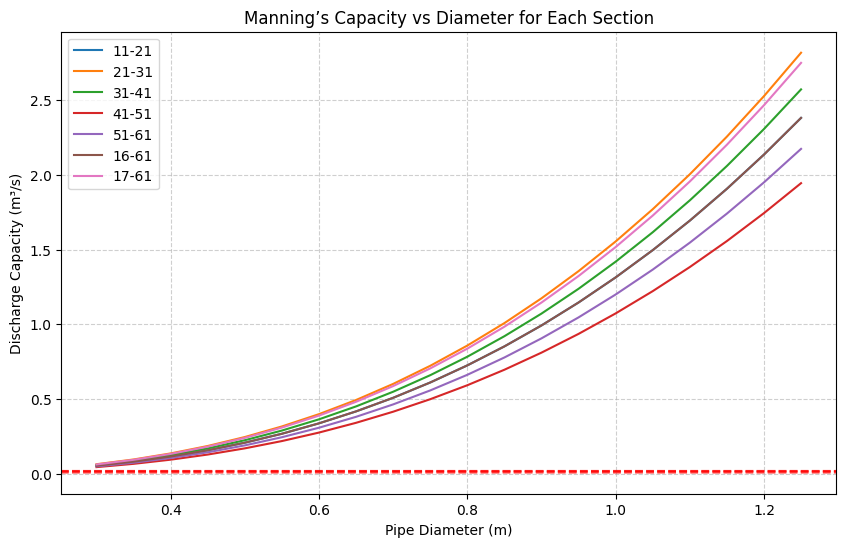

✅ Plot saved as Manning_Capacity_vs_Diameter.png
✅ Results saved as Drainage_Design_Results.xlsx


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =======================
# Basin Data (from Set 3)
# =======================
basin_data = pd.DataFrame({
    "Basin": ["I","II","III","IV","V","VI","VII"],
    "Area_ha": [0.5, 0.45, 0.57, 0.42, 0.2, 0.5, 0.38],
    "Res_pct": [58, 65, 60, 65, 60, 56, 58],
    "Lawn_pct": [32, 25, 30, 28, 36, 24, 32],
    "Paved_pct": [10, 10, 10, 7, 4, 20, 10],
    "Length_m": [62.2, 48.3, 60.2, 45.6, 32.7, 59.8, 49.1],
    "Slope": [0.009, 0.012, 0.015, 0.013, 0.009, 0.016, 0.012],
    "Kerby_n": [0.03, 0.025, 0.031, 0.023, 0.02, 0.032, 0.027]
})

# =======================
# Kerby’s Equation → Time of Concentration (min)
# =======================
basin_data["Tc_min"] = (
    0.0078 * (basin_data["Length_m"]*0.77 * basin_data["Kerby_n"]*0.77)
    / (basin_data["Slope"]**0.385)
)

# =======================
# Intensity from IDF Equation (use optimized_params from previous step)
# =======================
# Example placeholder (replace with your actual optimized_params from previous code)
# e.g., optimized_params = [12.4, 0.42, 10.3, 0.65]
K, x, a, n = 32.3879300195984, 0.02055901940063421, 1.2149050677583533, 0.9417387256848342
T = 5  # Return period (years)

basin_data["Intensity_mmhr"] = (K * (T ** x)) / ((basin_data["Tc_min"] + a) ** n)

# =======================
# Weighted Runoff Coefficient
# =======================
C_res, C_lawn, C_paved = 0.45, 0.20, 0.90
basin_data["C"] = (
    (C_res * basin_data["Res_pct"])
    + (C_lawn * basin_data["Lawn_pct"])
    + (C_paved * basin_data["Paved_pct"])
) / 100

# =======================
# Rational Formula → Peak Discharge (m³/s)
# =======================
basin_data["Q_m3s"] = (
    0.00278 * basin_data["C"] * basin_data["Intensity_mmhr"] * basin_data["Area_ha"]
)

print("=== Basin-wise Peak Discharge Data ===")
display(basin_data[["Basin", "Area_ha", "Tc_min", "Intensity_mmhr", "C", "Q_m3s"]])

# =======================
# Manning’s Formula Adequacy Check
# =======================
pipe_data = pd.DataFrame({
    "Section": ["11-21", "21-31", "31-41", "41-51", "51-61", "16-61", "17-61"],
    "Length_m": [1000, 400, 400, 500, 600, 700, 300],
    "Slope": [0.003, 0.0042, 0.0035, 0.002, 0.0025, 0.003, 0.004],
})

# Assign each pipe a basin flow (for demonstration)
pipe_data["Q_demand_m3s"] = basin_data["Q_m3s"].values[:len(pipe_data)]

n_manning = 0.013
diameters = np.arange(0.3, 1.3, 0.05)  # 0.3 m to 1.25 m

def manning_discharge(d, S, n):
    """Full-flow circular pipe discharge (m³/s)"""
    A = np.pi * d**2 / 4
    R = d / 4
    return (1 / n) * A * (R ** (2 / 3)) * (S ** 0.5)

pipe_results = []

for _, row in pipe_data.iterrows():
    Q_req = row["Q_demand_m3s"]
    S = row["Slope"]
    for d in diameters:
        Q_cap = manning_discharge(d, S, n_manning)
        if Q_cap >= Q_req:
            pipe_results.append((row["Section"], Q_req, d, Q_cap))
            break

pipe_check = pd.DataFrame(
    pipe_results,
    columns=["Section", "Q_required_m3s", "Adopted_D_m", "Q_capacity_m3s"]
)
pipe_check["Adequate"] = pipe_check["Q_capacity_m3s"] >= pipe_check["Q_required_m3s"]

print("\n=== Pipe Adequacy Check ===")
display(pipe_check)

# =======================
# Plot: Manning Capacity vs Diameter
# =======================
plt.figure(figsize=(10, 6))
for _, row in pipe_data.iterrows():
    S = row["Slope"]
    Q_req = row["Q_demand_m3s"]
    Q_caps = [manning_discharge(d, S, n_manning) for d in diameters]
    plt.plot(diameters, Q_caps, label=f'{row["Section"]}')
    plt.axhline(Q_req, color='r', linestyle='--', alpha=0.4)

plt.xlabel("Pipe Diameter (m)")
plt.ylabel("Discharge Capacity (m³/s)")
plt.title("Manning’s Capacity vs Diameter for Each Section")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.savefig("Manning_Capacity_vs_Diameter.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Plot saved as Manning_Capacity_vs_Diameter.png")

# =======================
# Save Results to Excel
# =======================
with pd.ExcelWriter("Drainage_Design_Results.xlsx") as writer:
    basin_data.to_excel(writer, sheet_name="Basin Calculations", index=False)
    pipe_check.to_excel(writer, sheet_name="Pipe Adequacy Check", index=False)

print("✅ Results saved as Drainage_Design_Results.xlsx")